# 3. WLS - local linear trend model

## Libraries

In [1]:
# Libraries

import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from scipy.stats import t

c:\ProgramData\anaconda3\envs\course02450\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


## Read data

In [2]:
# Read training data
df = pd.read_csv('DST_BIL54.csv')
#print(df.info())

# Convert 'time' column to datetime
df['time'] = pd.to_datetime(df['time'] + '-01', format='%Y-%m-%d', utc=True)
#print(df['time'])
#print(df['time'].dtype)

# Year to month for each of them
#df['year'] = df['time'].dt.year + df['time'].dt.month / 12
df['year'] = df['time'].dt.year + ((df['time'].dt.month-1) / 12)

# Make the output variable a floating point (i.e., decimal number)
df['total'] = df['total'].astype(float) / 1E6

# Round the 'total' column to 3 decimal points
df['total'] = df['total'].round(3)
df['year'] = df['year'].round(3)

# Divide into train and test set
test_start = pd.Timestamp('2024-01-01', tz='UTC')
df_train = df[df['time'] < test_start]
df_test = df[df['time'] >= test_start]

print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   time          84 non-null     datetime64[ns, UTC]
 1   total         84 non-null     float64            
 2   gasoline      84 non-null     int64              
 3   diesel        84 non-null     int64              
 4   fgas          84 non-null     int64              
 5   ngas          84 non-null     int64              
 6   electricity   84 non-null     int64              
 7   petroleum     84 non-null     int64              
 8   hydrogen      84 non-null     int64              
 9   methanol      84 non-null     int64              
 10  ethanol       84 non-null     int64              
 11  pluginhybrid  84 non-null     int64              
 12  otherfuels    84 non-null     int64              
 13  year          84 non-null     float64            
dtypes: datetime6

In [3]:
# Dimensions check and head
print('Dimensions check')
print(np.shape(df))
print(np.shape(df_train))
print(np.shape(df_test))

df.head()

Dimensions check
(84, 14)
(72, 14)
(12, 14)


,time,total,gasoline,diesel,fgas,ngas,electricity,petroleum,hydrogen,methanol,ethanol,pluginhybrid,otherfuels,year
0,2018-01-01 00:00:00+00:00,2.930,1781826,1136656,12,256,9304,0,81,0,0,2340,8,2018.000
1,2018-02-01 00:00:00+00:00,2.934,1783338,1138414,12,255,9343,0,80,0,0,2593,9,2018.083
2,2018-03-01 00:00:00+00:00,2.941,1787219,1141576,12,257,9399,0,77,0,0,2873,9,2018.167
3,2018-04-01 00:00:00+00:00,2.951,1793554,1144846,12,257,9548,0,77,0,0,3195,9,2018.250
4,2018-05-01 00:00:00+00:00,2.963,1799795,1149840,12,256,9665,0,77,0,0,3439,9,2018.333


In [4]:
# Keep data of interest

X=df_train['year']
y=df_train['total']

print(X.head())
print(y.head())

0    2018.000
1    2018.083
2    2018.167
3    2018.250
4    2018.333
Name: year, dtype: float64
0    2.930
1    2.934
2    2.941
3    2.951
4    2.963
Name: total, dtype: float64


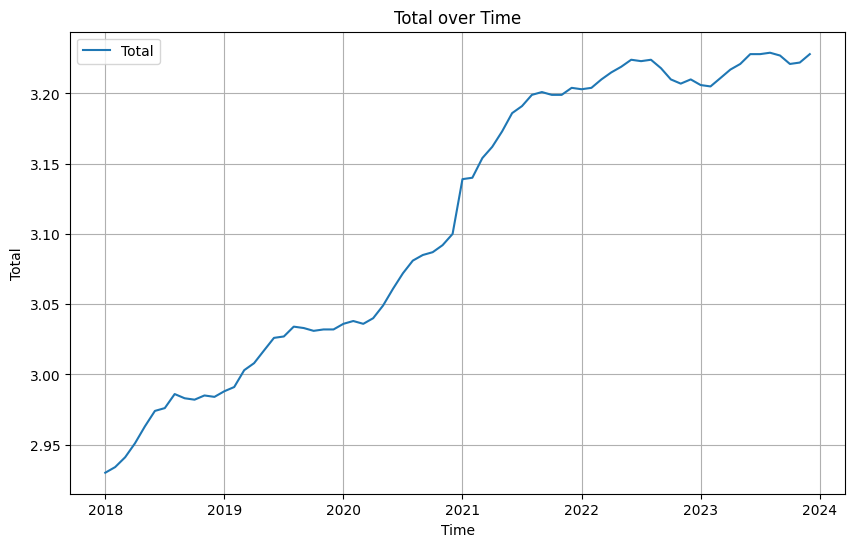

In [5]:
# plot data 

plt.figure(figsize=(10, 6))
plt.plot(X, y, label='Total')
plt.xlabel('Time')
plt.ylabel('Total')
plt.title('Total over Time')
plt.legend()
plt.grid(True)
plt.show()

## Solve sub questions

In [6]:
# 3.1 Describe the variance-covariance matrix

lambda_ = 0.9

# Create the diagonal matrix
powers = np.arange(len(X)-1, -1, -1)
diagonal_values = lambda_ ** powers
#Sigma = np.diag(diagonal_values)
Sigma = np.diag(1/diagonal_values)

# Display the lower right part of the matrix
lower_right_part = Sigma[-4:, -4:]  # Adjust the slice as needed
print("Lower right part of the matrix:")
print(lower_right_part)

print(' ')
print(np.mean(y))
# OLS SIgma 
Sigma_ols = np.diag(np.var(y)*np.ones(len(y)))
lower_right_part = Sigma_ols[-4:, -4:]  # Adjust the slice as needed
print("Lower right part of the OLS matrix:")
print(lower_right_part)

Lower right part of the matrix:
[[1.37174211 0.         0.         0.        ]
 [0.         1.2345679  0.         0.        ]
 [0.         0.         1.11111111 0.        ]
 [0.         0.         0.         1.        ]]
 
3.110347222222222
Lower right part of the OLS matrix:
[[0.01013581 0.         0.         0.        ]
 [0.         0.01013581 0.         0.        ]
 [0.         0.         0.01013581 0.        ]
 [0.         0.         0.         0.01013581]]


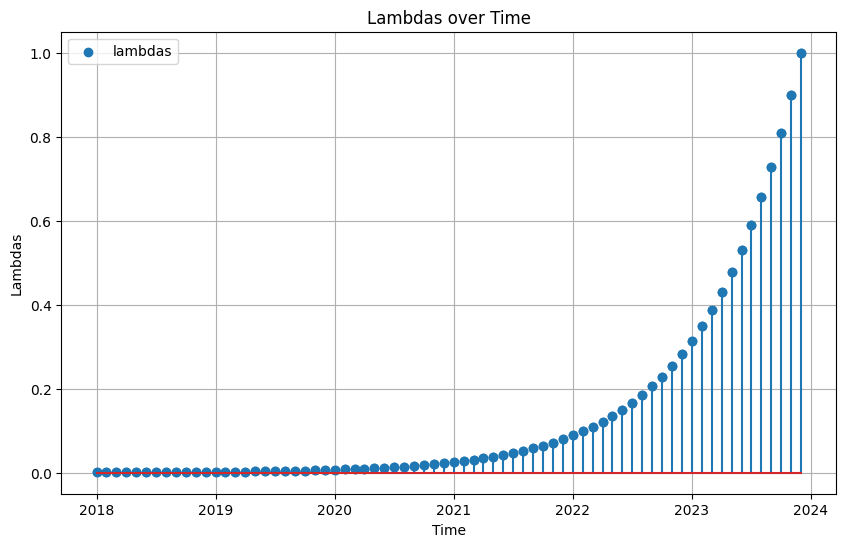

In [7]:
# 3.2 plot lambdas vs time

plt.figure(figsize=(10, 6))
plt.scatter(X, diagonal_values, label='lambdas')
plt.stem(X,diagonal_values)
plt.xlabel('Time')
plt.ylabel('Lambdas')
plt.title('Lambdas over Time')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
# 3.3 sum of all the λ-weights

# WLS
T=np.sum(diagonal_values)
print(T)

# OLS
lo=len(X)
print(lo)

9.994924712139436
72


~F~
[[9.99492471e+00 2.02214291e+04]
 [2.02214291e+04 4.09113892e+07]]
~h~
[[3.21332256e+01]
 [6.50111370e+04]]
~thetas~
[[-5.27812230e+01]
 [ 2.76774491e-02]]


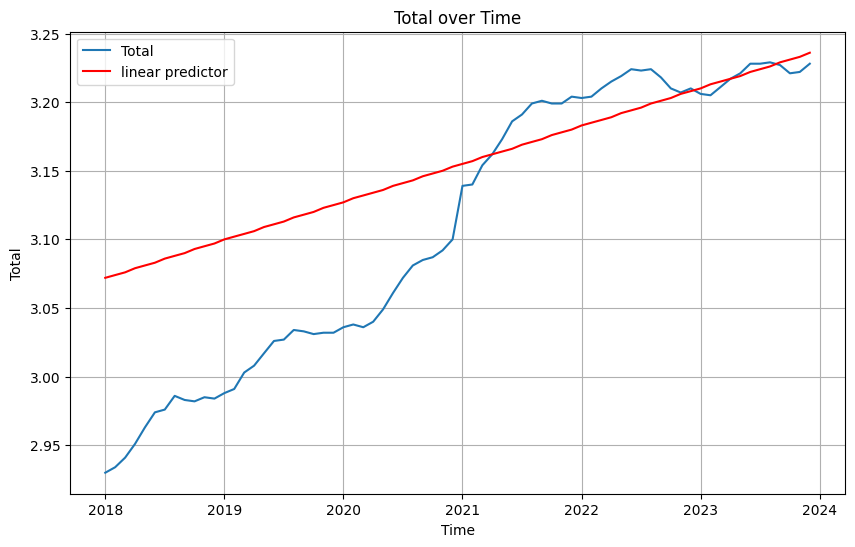

In [9]:
# 3.4 Estimate and present ˆθ1 and ˆθ2 corresponding to the WLS model with λ = 0.9.

def f(j):
    return np.array([[1], [j]])

# current F
F=np.zeros((2,2))
for i in range(len(X)): 
    F+=diagonal_values[i]*((f(X[i]) @ f(X[i]).T))

print("~F~")
print(F)

# current h
h=np.zeros((2,1))
for i in range(len(X)): 
    h+=(diagonal_values[i]*f(X[i]))*y[i]

print("~h~")
print(h)


# current thetas

thetas=np.linalg.inv(F) @ h
print("~thetas~")
print(thetas)

# linear predictor for thetas:
#thet_pred=list([f(i).T@thetas for i in X])
#thet_pred=[float(thet_pred[i][0]) for i in range(len(thet_pred))]
thet_pred=list(round(float((f(i).T @ thetas)[0, 0]), 3) for i in X)
#print(thet_pred)

# plot

plt.figure(figsize=(10, 6))
plt.plot(X, y, label='Total')
plt.plot(X,thet_pred, color='red',label='linear predictor')
plt.xlabel('Time')
plt.ylabel('Total')
plt.title('Total over Time')
plt.legend()
plt.grid(True)
plt.show()


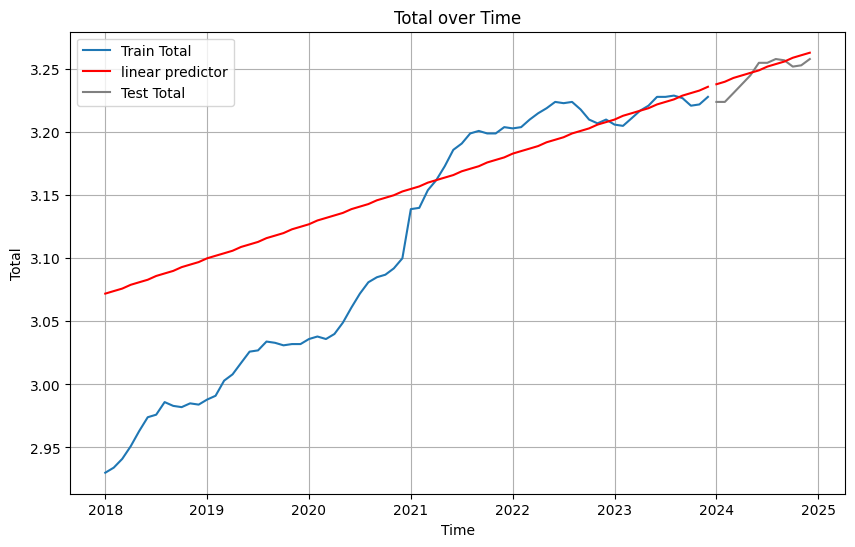

In [10]:
# 3.5 Make a forecast for the next 12 months 

X_test=df_test['year']
y_test=df_test['total']

# linear predictor for thetas:
#test_pred=list([f(i).T@thetas for i in X_test])
#test_pred=[float(test_pred[i][0]) for i in range(len(test_pred))]
test_pred=list(round(float((f(i).T@thetas)[0, 0]), 3) for i in X_test)

# plot

plt.figure(figsize=(10, 6))
plt.plot(X, y, label='Train Total')
plt.plot(X,thet_pred, color='red',label='linear predictor')
plt.plot(X_test, y_test, color='grey',label='Test Total')
plt.plot(X_test,test_pred, color='red')
plt.xlabel('Time')
plt.ylabel('Total')
plt.title('Total over Time')
plt.legend()
plt.grid(True)
plt.show()


[[-1.10468102e+02]
 [ 5.62002922e-02]]
[[-5.27812230e+01]
 [ 2.76774491e-02]]
[[-1.07222354e+02]
 [ 5.45943961e-02]]
[[-2.21095793e+01]
 [ 1.25186773e-02]]
[[-1.65931390e+01]
 [ 9.79270162e-03]]


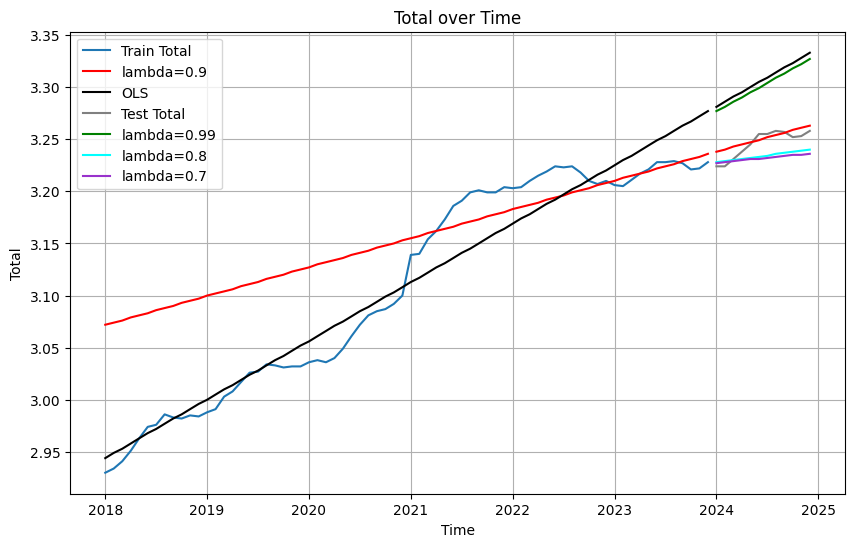

In [11]:
# 3.6 multiple lambdas

def predgen(l):
    powers = np.arange(len(X)-1, -1, -1)
    diagonal_values = l ** powers
    # current F
    F=np.zeros((2,2))
    for i in range(len(X)): 
        F+=diagonal_values[i]*((f(X[i]) @ f(X[i]).T))
    #print(F)

    # current h
    h=np.zeros((2,1))
    for i in range(len(X)): 
        h+=(diagonal_values[i]*f(X[i]))*y[i]
    #print(h)

    # current thetas

    thetas=np.linalg.inv(F) @ h
    print(thetas)

    # linear predictor for thetas:
    #thet_pred=list([f(i).T@thetas for i in X])
    #thet_pred=[float(thet_pred[i][0]) for i in range(len(thet_pred))]
    thet_pred=list(round(float((f(i).T @ thetas)[0, 0]), 3) for i in X)

    #test_pred=list([f(i).T@thetas for i in X_test])
    #test_pred=[float(test_pred[i][0]) for i in range(len(test_pred))]
    test_pred=list(round(float((f(i).T@thetas)[0, 0]), 3) for i in X_test)

    return thet_pred,test_pred

#ols
thet_pred1,test_pred1=predgen(1)
#0.9
thet_pred09,test_pred09=predgen(0.9)
#0.99
thet_pred099,test_pred099=predgen(0.99)
#0.8
thet_pred08,test_pred08=predgen(0.8)
#0.7
thet_pred07,test_pred07=predgen(0.7)



plt.figure(figsize=(10, 6))
plt.plot(X, y, label='Train Total')
plt.plot(X,thet_pred09, color='red',label='lambda=0.9')
plt.plot(X,thet_pred1, color='black',label='OLS')
plt.plot(X_test, y_test, color='grey',label='Test Total')
plt.plot(X_test,test_pred09, color='red')
plt.plot(X_test,test_pred1, color='black')
#MULTIL
plt.plot(X_test,test_pred099, color='green',label="lambda=0.99")
plt.plot(X_test,test_pred08, color='cyan',label="lambda=0.8")
plt.plot(X_test,test_pred07, color='darkorchid',label="lambda=0.7")


plt.xlabel('Time')
plt.ylabel('Total')
plt.title('Total over Time')
plt.legend()
plt.grid(True)
plt.show()
    

     1 & 2024.0 & 3.224 & 3.238 & 0.014 & 0.017 \\
     2 & 2024.083 & 3.224 & 3.24 & 0.016 & 0.017 \\
     3 & 2024.167 & 3.231 & 3.243 & 0.012 & 0.018 \\
     4 & 2024.25 & 3.238 & 3.245 & 0.007 & 0.018 \\
     5 & 2024.333 & 3.245 & 3.247 & 0.002 & 0.018 \\
     6 & 2024.417 & 3.255 & 3.249 & 0.006 & 0.018 \\
     7 & 2024.5 & 3.255 & 3.252 & 0.003 & 0.018 \\
     8 & 2024.583 & 3.258 & 3.254 & 0.004 & 0.019 \\
     9 & 2024.667 & 3.257 & 3.256 & 0.001 & 0.019 \\
     10 & 2024.75 & 3.252 & 3.259 & 0.007 & 0.019 \\
     11 & 2024.833 & 3.253 & 3.261 & 0.008 & 0.019 \\
     12 & 2024.917 & 3.258 & 3.263 & 0.005 & 0.02 \\


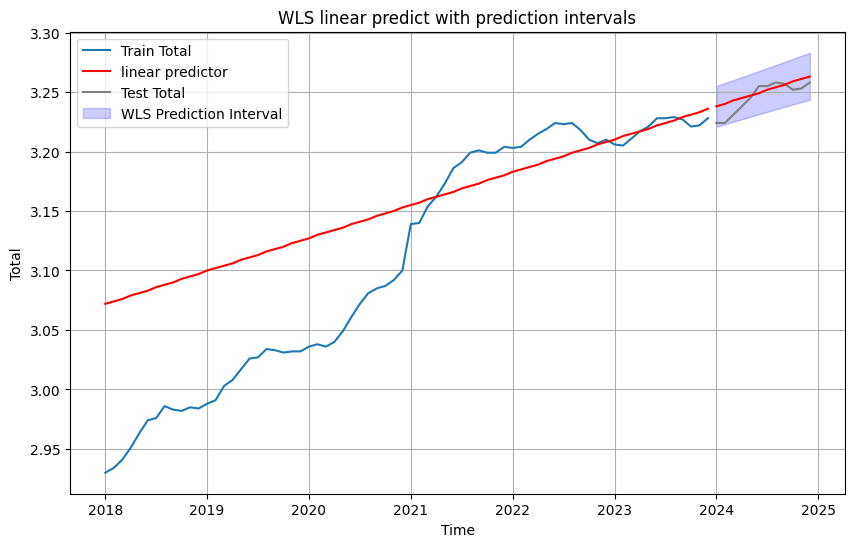

In [12]:
# prediction intervals

# Define variables
n = len(X)
p = 2
Xa = np.c_[np.ones(n), X]
ya = y

# WLS with lambda weights
lambda_ = 0.9
weights = lambda_ ** np.arange(n-1, -1, -1)
#print(weights)
SIGMA = np.diag(1 / weights)

# Estimate parameters with WLS
theta_WLS = np.linalg.inv(Xa.T @ np.linalg.inv(SIGMA) @ Xa) @ (Xa.T @ np.linalg.inv(SIGMA) @ ya)
yhat_wls = Xa @ theta_WLS

# Predictions from the WLS model
aXtest = np.c_[np.ones(len(X_test)), X_test]
y_pred_wls = aXtest @ theta_WLS

# Better prediction intervals
e_wls = y - yhat_wls
RSS_wls = e_wls.T @ np.linalg.inv(SIGMA) @ e_wls
Tmemory = np.sum(1 / np.diag(SIGMA))
sigma2_wls = float(RSS_wls / (Tmemory - p))
Vmatrix_pred = sigma2_wls * (1 + (aXtest @ np.linalg.inv(Xa.T @ np.linalg.inv(SIGMA) @ Xa)) @ aXtest.T)
y_pred_lwr_wls = y_pred_wls - t.ppf(0.80, df=n-1) * np.sqrt(np.diag(Vmatrix_pred))
y_pred_upr_wls = y_pred_wls + t.ppf(0.80, df=n-1) * np.sqrt(np.diag(Vmatrix_pred))

y_test=np.array(y_test)
X_test=np.array(X_test)

b=t.ppf(0.8, df=n-1) * np.sqrt(np.diag(Vmatrix_pred))
b=[round(i,3) for i in b]

for i in range(len(y_pred_lwr_wls)):
    a=abs(y_test[i]-test_pred[i])
    a=round(a,3)
    print("     "+str(i+1)+" & "+str(X_test[i])+" & "+str(y_test[i])+" & "+str(test_pred[i])+" & "+str(a)+" & "+str(b[i])+r" \\")

# plot

plt.figure(figsize=(10, 6))
plt.plot(X, y, label='Train Total')
plt.plot(X,thet_pred, color='red',label='linear predictor')
plt.plot(X_test, y_test, color='grey',label='Test Total')
plt.plot(X_test,test_pred, color='red')
plt.fill_between(X_test, y_pred_lwr_wls.flatten(), y_pred_upr_wls.flatten(), color='blue', alpha=0.2, label='WLS Prediction Interval')
plt.xlabel('Time')
plt.ylabel('Total')
plt.title('WLS linear predict with prediction intervals')
plt.legend()
plt.grid(True)
plt.show()
